# Hierarchical SHAP

This notebook contains code and examples for a hierarchical implementation of Shapley coefficients evaluation for images, with a fixed size of features per layer.



In [15]:
%matplotlib inline

#IMPORTS
from scipy.special import comb
from itertools import permutations
from functools import reduce
import time
import numpy as np
import torch 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

#INSTALL SHAP
!pip install shap
import shap

#IMPORT UTILS
!wget https://raw.githubusercontent.com/JacopoTeneggi/Interpretability/master/Utils/utils.py -P local_modules -nc
import local_modules.utils as Utils

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/utils.py’ already there; not retrieving.



## Load the model

This pre-trained model detects the presence of a cross in the image. If the cross is detected, the image is labeled with a ```1```, with a ```0``` otherwhise.

In [16]:
#LOAD PRE-TRAINED-NETWORK
model = Utils.Net()
model.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 
# model.eval() deactivates the dropout layer in the network
model.eval()

MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])
transf = transforms.Compose([ToTensor(), Normalize(mean=MEAN, std=STD)])

# LOAD TRAIN DATA
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data2/data.zip", 'r')
train_data_dir = "train_data_dir"
data.extractall(train_data_dir)
data.close()
train_batch_size = 64
train_data = ImageFolder(root = os.path.join(train_data_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = train_batch_size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
X, Y = next(train_loader)
# DEFINE MASK BACKGROUND WITH AVERAGE OF TRAINING SET
background = torch.mean(X, dim = 0)
background.detach()

# LOAD EXAMPLE IMAGES
ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data2", transform = transf)
example_batch_size = 2
exloader = DataLoader(ImF, batch_size = example_batch_size, shuffle = False, num_workers = 0)
exIter = iter(exloader)
images, labels = next(exIter)

# LABEL = 0
image0 = images[0]
label0 = labels[0]
input0 = image0.view(-1, 3, 100, 120)
output0 = model(input0)
print(output0)

# LABEL = 1
image1 = images[1]
label1 = labels[1]
input1 = image1.view(-1, 3, 100, 120)
output1 = model(input1)
print(output1)

tensor([[ 11.1314, -13.0076]], grad_fn=<AddmmBackward>)
tensor([[-79.0918,  88.0700]], grad_fn=<AddmmBackward>)


## Hierarchical SHAP implementation

This implementation relies on two classes:

1. ```HierarchicalSHAPExplainer```

2. ```HierarchicalSHAPNode```

### HierarchicalSHAPNode

It is the class that takes care of the actual evaluation of Shapley coefficients. It explores relevant features recursively so that we only get the deepest, most relevant features as an output. We do not save any intermediate nodes to save memory and reduce complexity.

### HierarchicalSHAPExplainer

It is a wrapper class that initialize the environment for the nodes. The ```explain()``` method simply calls the evaluation on the root node (i.e. the entire imagine).

In [49]:
class HierarchicalSHAPNode:
  """
  Represents the single feature
  """

  def __init__(self, explainer, depth, M, features, masks, path = None, score = None):
    self.explainer = explainer
    self.depth = depth
    self.M = M
    self.features = features
    self.masks = masks
    self.path = path
    self.score = score

  def computeShap(self, feature, predictions):
    feature_index = np.where(feature == 1)
    subset_indices = np.where(self.masks[:, feature_index[0][0]] == 0)
    subset = self.masks[subset_indices]
    added_subset = [np.add(sub, feature) for sub in subset] 
    deltas = np.array(list(zip(added_subset, subset)))
    diffs = [1/comb(self.M - 1, np.sum(b)) * (predictions[self.mask2str(a)] - predictions[self.mask2str(b)]) for a, b in deltas]
    phi = np.sum(diffs) / self.M
    return phi.detach().numpy()

  def mask2path(self, mask):
    if self.path is None:
      return [mask]
    else:
      return np.concatenate((self.path, mask))
  
  def mask2str(self, mask):
    return reduce(lambda a, b: str(a) + str(b), mask.astype(int)) 

  def str2mask(self, string):
    L = len(string) 
    mask = np.empty((L,))
    for i in range(L):
      mask[i] = int(string[i])
    return mask
  
  def pathMaskCoordinates(self, path, startRow = 0, endRow = 100, startColumn = 0, endColumn = 120):
    if path is not None:
      for layer in path:
        w = endColumn - startColumn
        h = endRow - startRow
        feature_index = np.where(layer == 1)[0]
        if feature_index == 0:
          endRow = startRow + h / 2
          endColumn = startColumn + w / 2
        elif feature_index == 1:
          endRow = startRow + h / 2
          startColumn += w / 2
        elif feature_index == 2:
          startRow += h / 2
          endColumn = startColumn + w / 2
        elif feature_index == 3:
          startRow += h / 2
          startColumn += w / 2
    return int(startRow), int(endRow), int(startColumn), int(endColumn)
  
  def maskInput(self, mask, rootInput, startRow, endRow, startColumn, endColumn, background):
    w = endColumn - startColumn
    h = endRow - startRow
    maskedInput = rootInput.clone();
    maskIndices = np.where(mask == 0)[0]
    for index in maskIndices:
      maskStartRow = startRow
      maskEndRow = endRow
      maskStartColumn = startColumn
      maskEndColumn = endColumn
      if index == 0:
        maskEndRow = startRow + h / 2
        maskEndColumn = startColumn + w / 2
      elif index == 1:
        maskEndRow = startRow + h / 2
        maskStartColumn += w / 2
      elif index == 2:
        maskStartRow += h / 2
        maskEndColumn = startColumn + w / 2
      elif index == 3:
        maskStartRow += h / 2
        maskStartColumn += w / 2
      maskStartRow = int(maskStartRow)
      maskEndRow = int(maskEndRow)
      maskStartColumn = int(maskStartColumn)
      maskEndColumn = int(maskEndColumn)
      maskedInput[:, maskStartRow:maskEndRow+1, maskStartColumn:maskEndColumn+1] = background[:, maskStartRow:maskEndRow+1, maskStartColumn:maskEndColumn+1]
    maskedInput = maskedInput.view(-1, 3, 100, 120)
    return maskedInput

  def rootPathInput(self, path, input, background, w = 120, h = 100):
    startRow, endRow, startColumn, endColumn = self.pathMaskCoordinates(path, 0, h, 0, w)
    rootInput = background.clone()
    rootInput[:, startRow:endRow+1, startColumn:endColumn+1] = input[:, startRow:endRow+1, startColumn:endColumn+1]
    return rootInput, startRow, endRow, startColumn, endColumn
  
  def nodeScores(self, model, input, background, label, threshold, minW, minH):
    # 
    rootInput, startRow, endRow, startColumn, endColumn = self.rootPathInput(self.path, input, background)
    rootw = endColumn - startColumn
    rooth = endRow - startRow
    # Stop when it reaches the deepest layer and return current node
    if (rootw < 2*minW) or (rooth < 2*minH):
      return self
    # If not, go down another level and compute shap coefficients for features
    predictions = {self.mask2str(mask): model(self.maskInput(mask, rootInput, startRow, endRow, startColumn, endColumn, background))[:, label] for mask in self.masks}
    phis = {self.mask2str(feature): self.computeShap(feature, predictions) for feature in self.features}

    # Update number of computed features
    self.explainer.computed += self.M

    # Convert SHAP dictionary to lists -> TODO: evaluate wether SHAP dictionary is necessary
    values = np.fromiter(phis.values(), dtype=float)
    keys = list(phis.keys())

    # Identify relevant features
    relevantIndices = np.where(values > threshold)[0]

    # Update number of rejected features
    self.explainer.rejected += self.M - len(relevantIndices)

    # Initialize children and recursively compute SHAP values
    children = []
    for relevantIndex in relevantIndices:
      childPath = np.array([self.str2mask(keys[relevantIndex])])
      if self.path is not None:
        childPath = np.concatenate((self.path, childPath))
      child = HierarchicalSHAPNode(self.explainer, self.depth + 1, self.M, self.features, self.masks, path = childPath, score = values[relevantIndex])
      children.append(child.nodeScores(model, input, background, label, threshold, minW, minH))
    return children

class HierarchicalSHAPExplainer:

  def __init__(self, model, background, M):
    self.computed = None
    self.rejected = None
    self.M = M
    self.MEAN = np.array([0.5, 0.5, 0.5])
    self.STD = np.array([0.5, 0.5, 0.5])
    self.input = input
    self.background = background
    self.masks = self.generateMasks() 
    self.features = np.identity(self.M, dtype=np.bool).reshape((self.M, self.M))

  def generateMasks(self):
    masks = np.ones((1,self.M), dtype=np.bool) # initialize masks array with all features on -> no need to compute permutations fro |S| = M
    for i in range(self.M):
      s = np.zeros(self.M, dtype=np.bool)
      s[0:i] = 1
      p = permutations(s)
      a = np.array(list(set(p)))
      masks = np.concatenate((masks, a))
    return masks

  def flatten(self, l):
    for el in l:
      if isinstance(el, list) and not isinstance(el, (str, bytes)):
        yield from self.flatten(el)
      else:
        yield el

  def addNodeMask(self, node, map):
    startRow, endRow, startColumn, endColumn = node.pathMaskCoordinates(node.path)
    map[startRow:endRow+1, startColumn:endColumn+1] = node.score

  def explain(self, input, background, label = None, threshold = 0, minW = 2, minH = 2):
    self.computed = 0
    self.rejected = 0
    mainNode = HierarchicalSHAPNode(self, 0, 4, self.features, self.masks, score = 1)
    nodes = mainNode.nodeScores(model, input, background, label, threshold, minW, minH)

    flatnodes = list(self.flatten(nodes))
    saliency_map = np.zeros((100, 120))
    for node in flatnodes:
      self.addNodeMask(node, saliency_map)

    return saliency_map

# Initialize explainer
explainer = HierarchicalSHAPExplainer(model, background, 4)

## Explaining label ```1``` for image labeled ```1```

We are testing with the lowest threshold possible (```0```) and the smallest input allowed (```1x1```) to evaluate performance in a worst-case scenario.


STARTED EXPLAINING IMAGE 1 @ 1596734199.20381 s
Computed 1764 features out of 12000 pixels (14.70 %) in 19218.530 ms -> 10.895 ms per feature
Rejected 579 features ( 32.82 %) @ threshold = 0 , minimum-input-shape = ( 1 1 )


Text(0.5, 1.0, 'Saliency map \n min size = (1,1), threshold = 0.0')

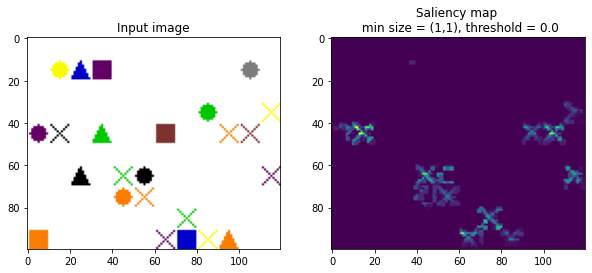

In [51]:
# EXPLAIN IMAGE 1 (with correct label)
t0 = time.time()
print("STARTED EXPLAINING IMAGE 1 @", t0, "s")
threshold = 0
minW = 1
minH = 1
saliency_map = explainer.explain(image1, background, label = 1, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
computed = explainer.computed
rejected = explainer.rejected
print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
print("Rejected", rejected, "features (", round(rejected/computed*100, 2), "%) @ threshold =", threshold, ", minimum-input-shape = (", minW, minH, ")")

im = Utils.input2image(image1, MEAN, STD)
ax1.imshow(im)
ax1.set_title("Input image")
ax2.imshow(saliency_map)
ax2.set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))

## Explaining label ```0``` for image labeled ```1```

STARTED EXPLAINING IMAGE 1 @ 1596733621.133831 s
Computed 4 features out of 12000 pixels ( 0.03 %) in 83.295 ms -> 20.824 ms per feature
Rejected 4 features ( 100.0 %) @ threshold = 0 , minimum-input-shape = ( 1 1 )


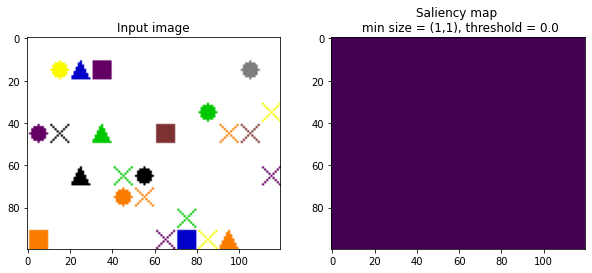

In [45]:
# EXPLAIN LABEL 0 FOR IMAGE 1
t0 = time.time()
print("STARTED EXPLAINING IMAGE 1 @", t0, "s")
threshold = 0
minW = 1
minH = 1
saliency_map = explainer.explain(image1, background, label = 0, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
computed = explainer.computed
rejected = explainer.rejected
print("Computed", computed ,"features out of", 100*120, "pixels (", round(computed/120, 2), "%) in", round((tf -t0) * 1000, 3), "ms ->", round(((tf-t0)*1000)/computed, 3), "ms per feature")
print("Rejected", rejected, "features (", round(rejected/computed*100, 2), "%) @ threshold =", threshold, ", minimum-input-shape = (", minW, minH, ")")

im = Utils.input2image(image1, MEAN, STD)
ax1.imshow(im)
ax1.set_title("Input image")
ax2.imshow(saliency_map)
ax2.set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))

## Explaining label ```0``` for image labeled ```0```

We are testing with the lowest threshold possible (```0```) and the smallest input allowed (```1x1```) to evaluate performance in a worst-case scenario. 

In [62]:
# EXPLAIN IMAGE 0
t0 = time.time()
print("STARTED EXPLAINING IMAGE @", t0, "s")
threshold = 0
minW = 1
minH = 1
saliency_map = explainer.explain(image0, background, label = 0, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
print("Computed", computed ,"features out of", 100*120, "pixels (", round(computed/120, 2), "%) in", round((tf -t0) * 1000, 3), "ms ->", round(((tf-t0)*1000)/computed, 3), "ms per feature")
print("Rejected", rejected, "features (", round(rejected/computed*100, 2), "%) @ threshold =", threshold, ", minimum-input-shape = (", minW, minH, ")")

im = Utils.input2image(image0, MEAN, STD)
ax1.imshow(im)
ax1.set_title("Input image")
ax2.imshow(saliency_map)
ax2.set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))

STARTED EXPLAINING IMAGE 0 @ 1596735651.83955 s
Computed 328 features out of 12000 pixels ( 2.73 %) in 10342.355 ms -> 31.532 ms per feature
Rejected 218 features ( 66.46 %) @ threshold = 0 , minimum-input-shape = ( 1 1 )


Text(0.5, 1.0, 'Saliency map \n min size = (1,1), threshold = 0.0')

## Trying out different minimal feature sizes and thresholds

These examples explain label ```1``` for the positive (labeled as ```1```) image.


STARTED EXPLAINING IMAGE @ 1596735402.9976838 s
Computed 20 features out of 12000 pixels (0.17 %) in 209.906 ms -> 10.495 ms per feature
Rejected 9 features (45.00 %) @ threshold = 0.0 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1596735403.210003 s
Computed 20 features out of 12000 pixels (0.17 %) in 222.243 ms -> 11.112 ms per feature
Rejected 10 features (50.00 %) @ threshold = 0.5 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1596735403.4343555 s
Computed 20 features out of 12000 pixels (0.17 %) in 200.147 ms -> 10.007 ms per feature
Rejected 10 features (50.00 %) @ threshold = 1.5 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1596735403.6364648 s
Computed 20 features out of 12000 pixels (0.17 %) in 223.044 ms -> 11.152 ms per feature
Rejected 10 features (50.00 %) @ threshold = 2.0 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1596735403.8620129 s
Computed 20 features out of 12000 pixels (0.17 %) in 218.794 ms -> 10.940

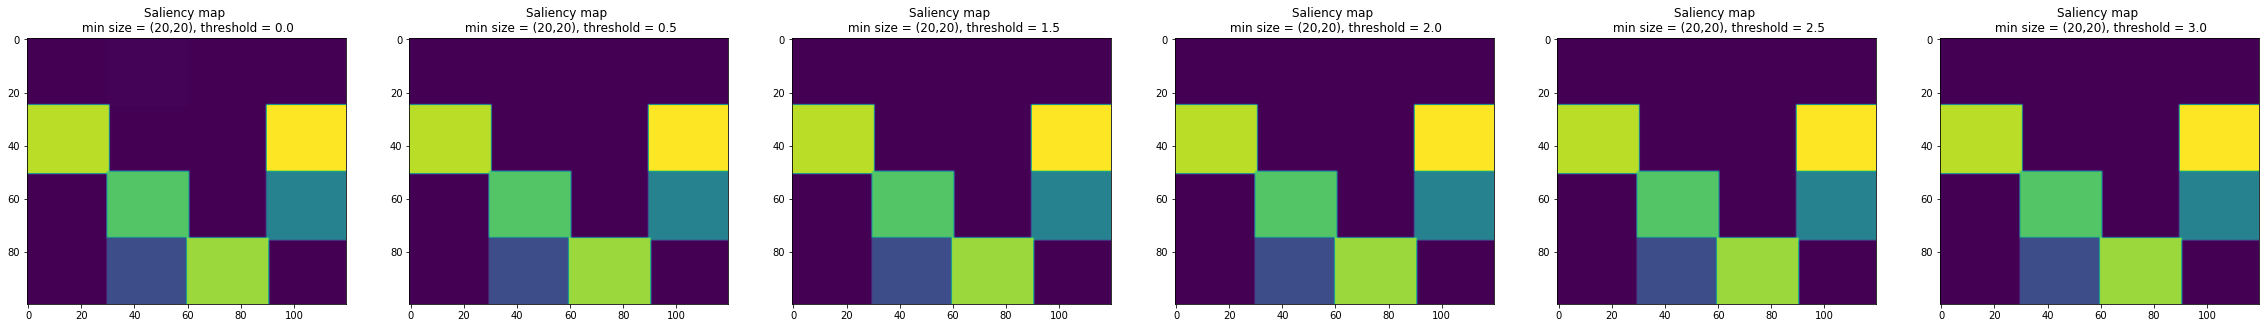

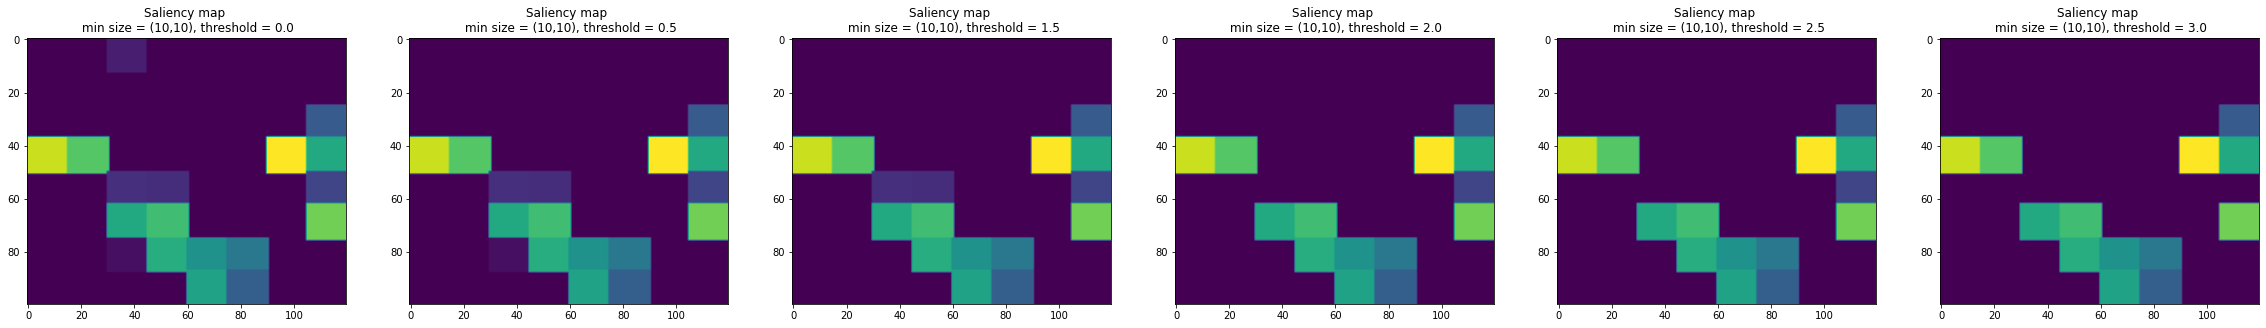

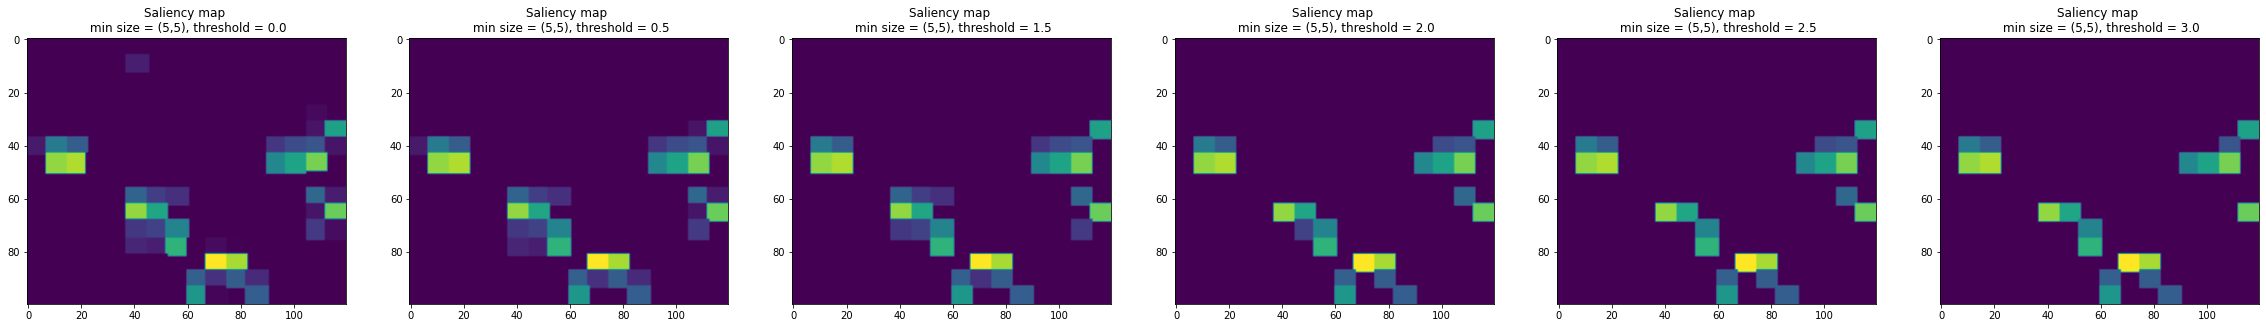

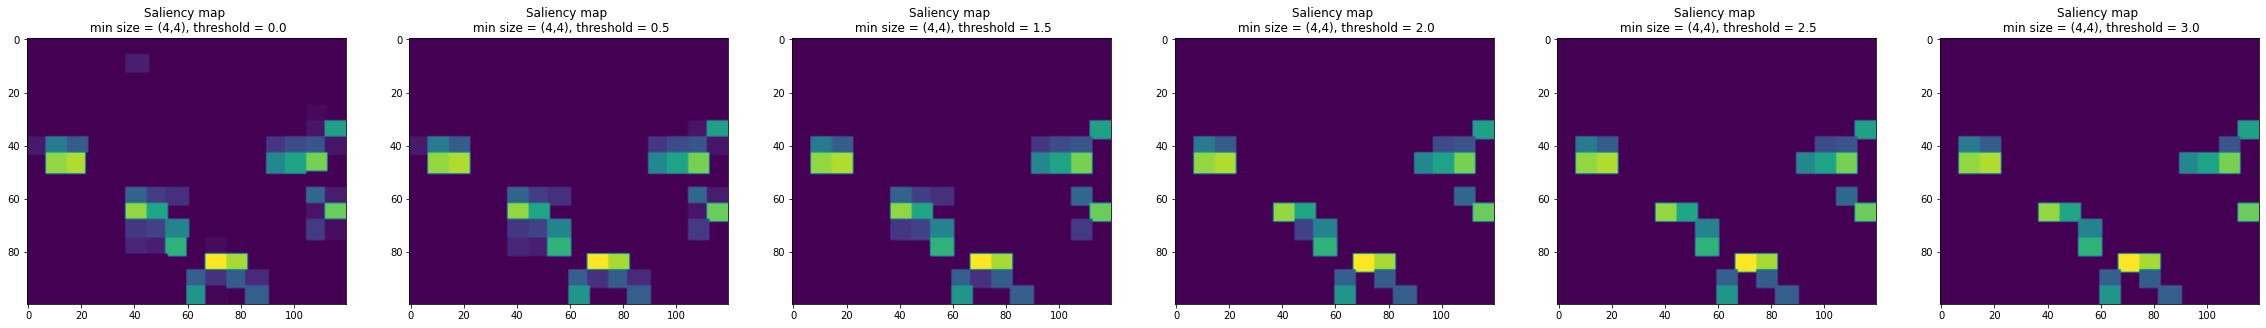

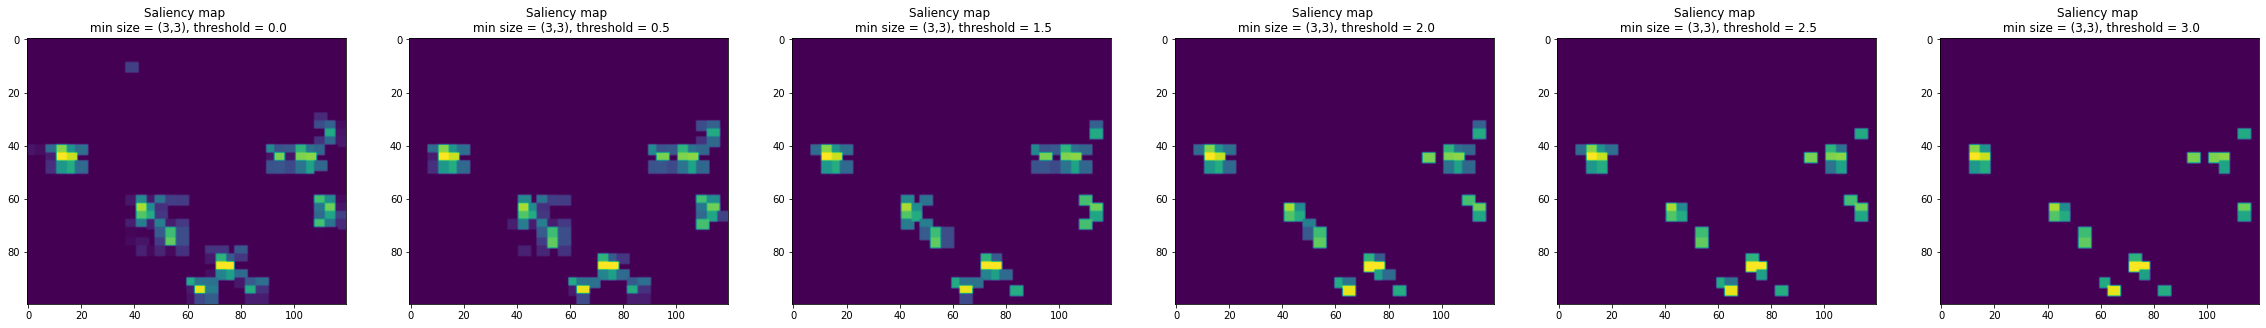

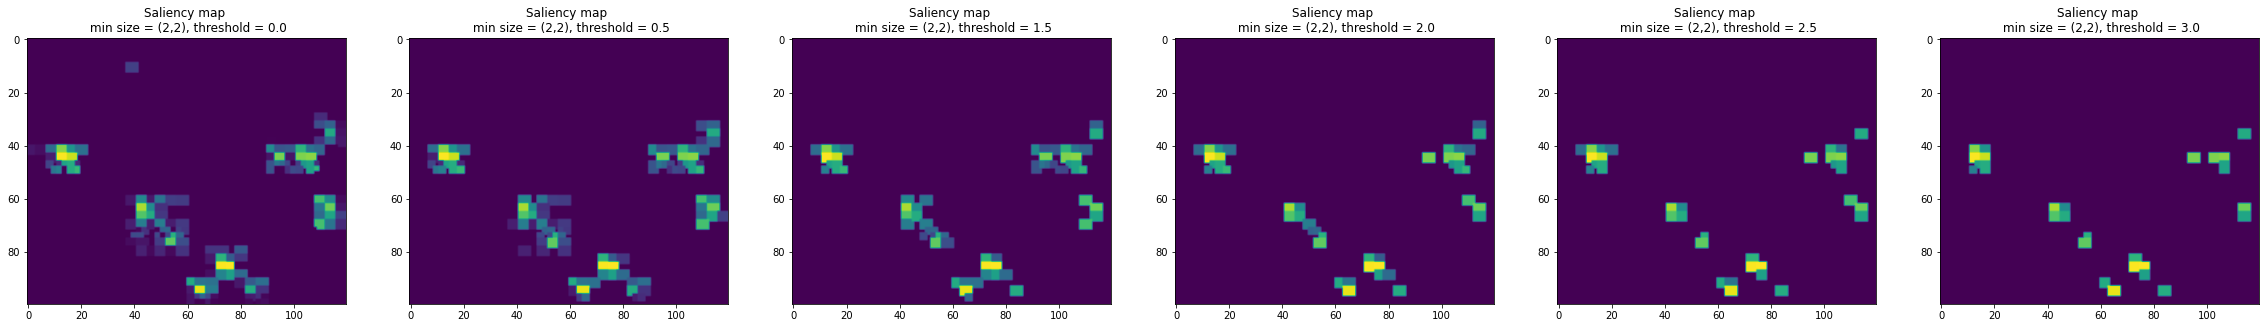

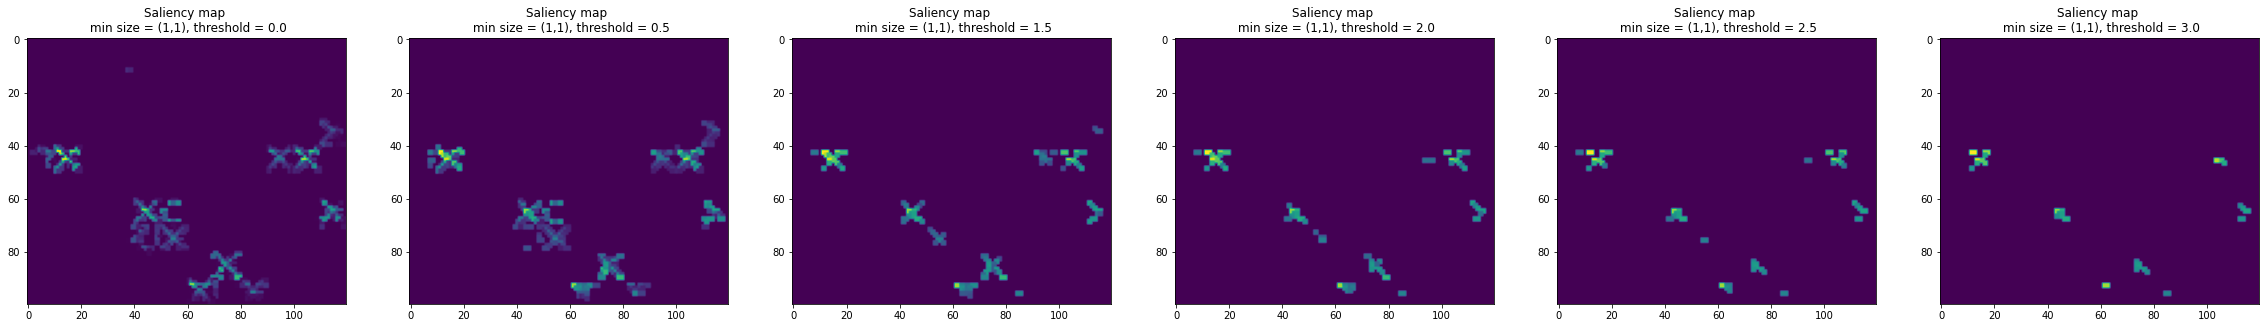

In [61]:
sizes = np.array([[20,20], [10,10], [5, 5], [4, 4], [3, 3], [2, 2], [1, 1]])
thresholds = np.array([0., 0.5, 1.5, 2., 2.5, 3], dtype=float)

L1 = len(thresholds)
L2 = len(sizes)
X = np.zeros((L1, L2))
Y1 = np.zeros((L1, L2))
Y2 = np.zeros((L1, L2))
  
for i in np.arange(L2):
  size = sizes[i]
  minW = size[0]
  minH = size[1]
  fig = plt.figure(figsize=(40, 10))
  axes = fig.subplots(1, L1)
  for j in np.arange(L1):
    threshold = thresholds[j]
    t0 = time.time()
    print("\nSTARTED EXPLAINING IMAGE @", t0, "s")
    saliency_map = explainer.explain(image1, background, label = 1, threshold = threshold, minW = minW, minH = minH)
    tf = time.time()
    computed = explainer.computed
    rejected = explainer.rejected
    X[j, i] = minW
    Y1[j, i] = computed
    Y2[j, i] = rejected
    print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
    print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))
    axes[j].imshow(saliency_map)
    axes[j].set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))


### Plot number of features computed and rejection rate as a function of minimal feature size

We define the feature rejection rate as the percentage of computed features that are considered non-relevant.

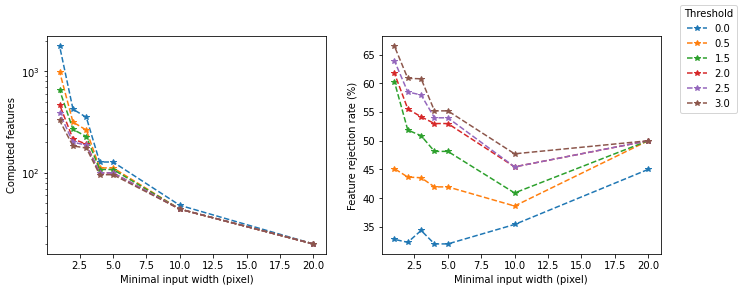

In [74]:
fig = plt.figure(figsize=(11, 4))
ax1, ax2 = fig.subplots(1, 2)

lines = []
labels = []

for i in np.arange(L1):
  l = ax1.plot(X[i, :], Y1[i, :], '*--')[0]
  ax2.plot(X[i, :], Y2[i, :]/Y1[i, :] * 100, '*--')
  lines.append(l)
  labels.append(thresholds[i])

ax1.set_xlabel('Minimal input width (pixel)')
ax1.set_ylabel('Computed features')
ax1.set_yscale('log')
ax2.set_xlabel('Minimal input width (pixel)')
ax2.set_ylabel('Feature rejection rate (%)')
fig.legend(lines, labels, title = "Threshold")
plt.show()